In [194]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from scipy.stats import poisson

In [195]:
FILES_PATH = "/home/guillaume/pythia/code/data/"

In [196]:
fixtures_data = pd.read_csv(f"{FILES_PATH}fixtures.csv", delimiter=",")
odds_data = pd.read_csv(f"{FILES_PATH}odds.csv", delimiter=",")
players_data = pd.read_csv(f"{FILES_PATH}players.csv", delimiter=",")
results_data = pd.read_csv(f"{FILES_PATH}results.csv", delimiter=",")
startingXI_data = pd.read_csv(f"{FILES_PATH}startingXI.csv", delimiter=",")
teams_data = pd.read_csv(f"{FILES_PATH}teams.csv", delimiter=",")

Encode the outcome of the game in the results dataset
- 0 if Home Team won
- 1 if a draw
- 2 if Away Team won 

In [197]:
def game_outcome_ground_truth(df : pd.DataFrame) -> pd.DataFrame:
    """
    Encode the results of the game.
    - 0 if Home Team won
    - 1 if a draw
    - 2 if Away Team won 
    """
    df["GameOutcome"] = 0 
    df.loc[df["HomeScore"] == df["AwayScore"], "GameOutcome"] = 1  
    df.loc[df["HomeScore"] < df["AwayScore"], "GameOutcome"] = 2
    return df

results_data = game_outcome_ground_truth(results_data)

We extract the unique id of each team and make it a global list as it can be useful throughout the model implementation.

In [412]:
ALL_TEAM_IDS = results_data["HomeTeamID"].sort_values().unique().tolist()

Split dataset into a train dataset for season 1 and a test dataset for season 2

In [ ]:
results_data_season1 = results_data.copy()
results_data_season2 = results_data.copy()

results_data_season1 = results_data_season1[results_data_season1["SeasonID"]==1]
results_data_season2 = results_data_season2[results_data_season2["SeasonID"]==2]

## Feature engineering

In [241]:
class DataPreprocessing:    
    def generate_inputs_model(self, df : pd.DataFrame, home_boolean : bool):
        """
        Generate the model input dataset as well as the ground truth - here the number of goals.  
        """
        if home_boolean:
            X = df[[x for x in df.columns if x.startswith("in_")]]
            y = df[["HomeScore"]]
        else:
            X = df[[x for x in df.columns if x.startswith("in_")]]
            y = df[["AwayScore"]]
        return X, y
    
    def merge_results_stats(self, results_df : pd.DataFrame, stats_df : pd.DataFrame, _home_boolean : bool) -> pd.DataFrame:
        """
        Add the new features to the existing results dataset. 
        """
        if _home_boolean:
            results_df = results_df.merge(stats_df, on = ["HomeTeamID"], how = "left")
        else:
            results_df = results_df.merge(stats_df, on = ["AwayTeamID"], how = "left")
        return results_df

### General statistics for season 1

In [263]:
# results_data_season1, test_results = train_test_split(results_data_season1, test_size=0.2)
train_results = results_data_season1
test_results = results_data_season2

In [264]:
def season_statistics(df : pd.DataFrame) -> list[int, int, float, float]:
    """
    Calculate the total number of goals scored at home/away. 
    As well the average number of goals scored at home/away. 
    """
    return df.HomeScore.sum(), df.AwayScore.sum(), df.HomeScore.mean(), df.AwayScore.mean()
TOTAL_LEAGUE_GOALS_HOME, TOTAL_LEAGUE_GOALS_AWAY, AVERAGE_LEAGUE_GOALS_HOME, AVERAGE_LEAGUE_GOALS_AWAY = season_statistics(results_data_season1)

### Team-oriented statistics

- Calculation of attack & defence strengths for home & away teams
- Shots and goals conceded features generation

In [265]:
def generate_average_stats_home(df : pd.DataFrame) -> pd.DataFrame:
    """
    Calculate the average number of goals scored/conceded for every home team. 
    """
    return df.groupby(["HomeTeamID"]).agg(
        in_HomeSeasonGoalsScoredAvg = ("HomeScore", "mean"),
        in_HomeSeasonGoalsConcededAvg = ("AwayScore", "mean"),
        in_HomeSeasonShotsAvg = ("HomeShots", "mean"),
        in_HomeSeasonShotsConcededAvg = ("AwayShots", "mean"),
        # in_HomeDraws = ("DrawBoolean", "sum")
    ).reset_index()

def generate_average_stats_away(df : pd.DataFrame) -> pd.DataFrame:
    """
    Calculate the average number of goals scored/conceded for every away team.  
    """
    return df.groupby(["AwayTeamID"]).agg(
    in_AwaySeasonGoalsScoredAvg = ("AwayScore", "mean"),
    in_AwaySeasonGoalsConcededAvg = ("HomeScore", "mean"),
    in_AwaySeasonShotsAvg = ("AwayShots", "mean"),
    in_AwaySeasonShotsConcededAvg = ("HomeShots", "mean"),
    # in_AwayDraws = ("DrawBoolean", "sum")
).reset_index()

In [266]:
def calculate_strength_home(df : pd.DataFrame) -> pd.DataFrame:
    """
    Divide the average number of goals scored by a home team by the average number of home goals scored thoughout the season.
    """
    df["in_HomeAttackStrength"] = df["in_HomeSeasonGoalsScoredAvg"]/AVERAGE_LEAGUE_GOALS_HOME
    df["in_HomeDefenceStrength"] = df["in_HomeSeasonGoalsConcededAvg"]/AVERAGE_LEAGUE_GOALS_AWAY
    return df.drop(columns=["in_HomeSeasonGoalsScoredAvg", "in_HomeSeasonGoalsConcededAvg"])

def calculate_strength_away(df : pd.DataFrame) -> pd.DataFrame:
    """
    Divide the average number of goals scored by an away team by the average number of away goals scored thoughout the season.
    """
    df["in_AwayAttackStrength"] = df["in_AwaySeasonGoalsScoredAvg"]/AVERAGE_LEAGUE_GOALS_AWAY
    df["in_AwayDefenceStrength"] = df["in_AwaySeasonGoalsConcededAvg"]/AVERAGE_LEAGUE_GOALS_HOME
    return df.drop(columns=["in_AwaySeasonGoalsScoredAvg", "in_AwaySeasonGoalsConcededAvg"])

Home advantage added as a feature

In [267]:
def intercept_term_advantage(df : pd.DataFrame) -> pd.DataFrame:
    """
    Add an intercept term to capture any constant effects such as the advantage of playing at home.
    """
    df["in_InterceptTerm"] = 1
    return df

In [268]:
# data_preprocessing = DataPreprocessing()
# df_features_home = generate_average_stats_home(results_data_season1)
# df_features_away = generate_average_stats_away(train_results)
# df_features_home = calculate_strength_home(df_features_home)
# df_features_away = calculate_strength_away(df_features_away)

# df_features_home["in_StrengthDifference"] = abs(df_features_home["in_HomeAttackStrength"] - df_features_away["in_AwayDefenceStrength"])
# df_features_away["in_StrengthDifference"] = abs(df_features_home["in_HomeAttackStrength"] - df_features_away["in_AwayDefenceStrength"])

# df_features_home = intercept_term_advantage(df_features_home)
# df_features_away = intercept_term_advantage(df_features_away)

# train_results_home = data_preprocessing.merge_results_stats(train_results, df_features_home, True)
# train_results_away = data_preprocessing.merge_results_stats(train_results, df_features_away, False)

In [269]:
def generate_features_dataset(df):
    df_features_home = generate_average_stats_home(df)
    df_features_away = generate_average_stats_away(df)
    df_features_home = calculate_strength_home(df_features_home)
    df_features_away = calculate_strength_away(df_features_away)

    df_features_home["in_StrengthDifference"] = abs(df_features_home["in_HomeAttackStrength"] - df_features_away["in_AwayDefenceStrength"])
    df_features_away["in_StrengthDifference"] = abs(df_features_home["in_HomeAttackStrength"] - df_features_away["in_AwayDefenceStrength"])

    df_features_home = intercept_term_advantage(df_features_home)
    df_features_away = intercept_term_advantage(df_features_away)

    return df_features_home, df_features_away

df_features_home, df_features_away = generate_features_dataset(train_results)
# test_results_home, test_results_away = generate_features_dataset(test_results)

In [270]:
data_preprocessing = DataPreprocessing()
train_results_home = data_preprocessing.merge_results_stats(train_results, df_features_home, True)
train_results_away = data_preprocessing.merge_results_stats(train_results, df_features_away, False)

In [271]:
# def get_statistics_per_team(df : pd.DataFrame, home_boolean : bool) -> pd.DataFrame:
#     """
#     Return a dataframe with a unique home/away team ID and the associated season features.
#     It simplifies data manipualtion and the testing phase.
#     """
#     team_id = "AwayTeamID"
#     if home_boolean:
#         team_id = "HomeTeamID"
#     return df[[team_id] + [x for x in df.columns if x.startswith("in_")]]\
#         .drop_duplicates()\
#             .sort_values(by=[team_id])\
#                 .reset_index(drop=True)

## Input dataset creation and model training

In [272]:
class TrainModel(DataPreprocessing):
    def __init__(self):
        pass
    
    def model_training(self, X : pd.DataFrame, y : pd.DataFrame):
        """
        Fit a Poisson regression model to the train data. 
        """
        return sm.GLM(y, X, family=sm.families.Poisson()).fit()

In [273]:
train_model = TrainModel()
## Generate the model inputs and ground truths for home & away team
X_home, y_home = train_model.generate_inputs_model(train_results_home, True)
X_away, y_away = train_model.generate_inputs_model(train_results_away, False)

## - Build a Poisson regression model to generate predicitons for team playing at home
## - Build another model for team playing away 

model_home = train_model.model_training(X_home, y_home)
model_away = train_model.model_training(X_away, y_away)

## Model testing

In [215]:
class TestModel:
    def __init__(self):
        pass

    def predict_expected_value_goal(self, model, X : pd.Series) -> np.array:
        """
        Predict the expected value of the poisson distribution for a fixture and a team. 
        """
        return model.predict(X.values.tolist())
    
    def random_draw_goal_distrib(self, predicted_lambda : np.array, n : int = 10000) -> np.array:
        """
        Draw samples from a Poisson distribution given its expected value. 
        """
        return np.random.poisson(lam=predicted_lambda, size=(n, len(predicted_lambda))).flatten()
    
    def count_goals(self, simulated_goals : np.array, home_boolean : bool) -> pd.Series:
        """
        Calculate the probability for a set of goals to be scored for a certain fixture. 
        """
        if home_boolean:
            return simulated_goals.value_counts().sort_index().rename("HomeGoalsProbability")/len(simulated_goals)
        else:
            return simulated_goals.value_counts().sort_index().rename("AwayGoalsProbability")/len(simulated_goals)
        
    def generate_goals_proba_table(self,home_goals_proba : pd.Series, away_goals_proba : pd.Series) -> pd.DataFrame:
        """
        Concatenate the goal probabilities for home and away team. 
        """
        return pd.concat([home_goals_proba, away_goals_proba], axis = 1).sort_index().fillna(0)
    
    def calculate_scores_proba(self, df : pd.DataFrame) -> pd.DataFrame:
        """
        Multiply the probability of Home Team to score X goals with the probability of Away Team to score Y goals.
        Return a matrix containing the probability of every possible outcome (e.g.: 0-1, 2-2, etc.) 
        """
        scores_proba_matrix = np.outer(df["HomeGoalsProbability"].values, df["AwayGoalsProbability"].values)
        return pd.DataFrame(scores_proba_matrix, index = df.index, columns = df.index)
    
    def calculate_outcome_probability(self, df : pd.DataFrame) -> list[float, float, float]:
        """
        Calculate the probability for the home/away team to win, draw or lose.
        Given the matrix containing the every outcome probability, it sums the all the probabilities for:
        - Home Team to win
        - Away Team to win
        - Draw
        """
        probability_home_win = 0
        probability_away_win = 0
        probability_draw = 0
        for i in range(len(df)):
            for j in range(len(df)):
                if i==j:
                    probability_draw += df.iloc[i, j]
                elif i<j:
                    probability_away_win += df.iloc[i, j]
                else:
                    probability_home_win += df.iloc[i, j]
        return probability_home_win, probability_draw, probability_away_win
    
    def game_outcome(self, probability_win_home : float, probability_draw : float, probability_win_away : float) -> int:
        """
        Find the result with the highest probability and return it as the game outcome.  
        """
        return np.argmax([probability_win_home, probability_draw, probability_win_away])

In [286]:
test_results_home = test_results.merge(df_features_home, on = "HomeTeamID", how = "left")
test_results_away = test_results.merge(df_features_away, on = "AwayTeamID", how = "left")

data_preprocessing = DataPreprocessing()
X_test_home, _ = data_preprocessing.generate_inputs_model(test_results_home, home_boolean=True)
X_test_away, _ = data_preprocessing.generate_inputs_model(test_results_away, home_boolean=False)

In [122]:
# n_goals = 8
# prob_home_win = sum(
# poisson.pmf(i, predicted_lambda_home) * sum(poisson.pmf(j, predicted_lambda_away) for j in range(i))
# for i in range(n_goals))

# prob_away_win = sum(
# poisson.pmf(j, predicted_lambda_away) * sum(poisson.pmf(i, predicted_lambda_home) for i in range(j)) for j in range(n_goals)
# )

# prob_draw = sum(poisson.pmf(i, predicted_lambda_home) * poisson.pmf(i, predicted_lambda_away) for i in range(n_goals))

In [289]:
test_model = TestModel()

probability_win_home_test = []
probability_draw_test = []
probability_win_away_test = []
game_outcome_test = []
for i in range(len(X_test_home)):
    X_test_home_i = X_test_home.iloc[i]
    X_test_away_i = X_test_away.iloc[i]

    predicted_lambda_home = test_model.predict_expected_value_goal(model_home, X_test_home_i)
    predicted_lambda_away = test_model.predict_expected_value_goal(model_away, X_test_away_i)

    simulated_goals_home = test_model.random_draw_goal_distrib(predicted_lambda_home)
    simulated_goals_away = test_model.random_draw_goal_distrib(predicted_lambda_away)

    home_goals_proba = test_model.count_goals(pd.Series(simulated_goals_home), home_boolean = True)
    away_goals_proba = test_model.count_goals(pd.Series(simulated_goals_away), home_boolean = False)
    goals_proba_matrix = test_model.generate_goals_proba_table(home_goals_proba, away_goals_proba)
    
    # goals_proba_matrix = goals_proba_matrix[goals_proba_matrix.index<=5]
    
    scores_proba_df = test_model.calculate_scores_proba(goals_proba_matrix)
    probability_win_home, probability_draw, probability_win_away  = test_model.calculate_outcome_probability(scores_proba_df)

    probability_win_home_test.append(probability_win_home)
    probability_draw_test.append(probability_draw)
    probability_win_away_test.append(probability_win_away)
    game_outcome_test.append(test_model.game_outcome(probability_win_home, probability_draw, probability_win_away))


In [301]:
outcomes_df = pd.DataFrame({
    "HomeTeamWinProbability" : probability_win_home_test,
    "TeamsDrawProbability" : probability_draw_test,
    "AwayTeamWinProbability" : probability_win_away_test,
    "PredictedGameOutcome" : game_outcome_test
})

outcomes_df["PredictedGameOutcome"].value_counts()

PredictedGameOutcome
0    490
2    259
1      7
Name: count, dtype: int64

### Compare results 2 prediction with the ground truth

In [352]:
def merge_season2_outcomes(df_season : pd.DataFrame, df_results : pd.DataFrame) -> pd.DataFrame:
    return pd.concat([df_season.reset_index(drop=True), df_results.reset_index(drop=True)], axis=1)
test_results_prediction = merge_season2_outcomes(test_results, outcomes_df)

Calculate the predicted odds using the probabilities computed by the model for season 2

In [353]:
def calculate_predicted_odds(df : pd.DataFrame) -> pd.DataFrame:
    df["PredictedOddsHomeWin"] = 1/df["HomeTeamWinProbability"]
    df["PredictedOddsDraw"] = 1/df["TeamsDrawProbability"]
    df["PredictedOddsAwayWin"] = 1/df["AwayTeamWinProbability"]
    return df
test_results_prediction = calculate_predicted_odds(test_results_prediction)

Calculate the expected value of points for every team at every game
$$E[X] = \sum_{x=0,1,3} x*P(X=x)$$
- x represents the possible points a team can earn in a game 
- P(X=x) is the probability of earning x points, as computed by the model.

In [ ]:
def calculate_points_expected_value_per_game(df : pd.DataFrame) -> pd.DataFrame:
    df["HomePredictedPoints"] = df["HomeTeamWinProbability"]*3 + df["TeamsDrawProbability"]
    df["AwayPredictedPoints"] = df["AwayTeamWinProbability"]*3 + df["TeamsDrawProbability"]
    return df
test_results_prediction = calculate_points_expected_value_per_game(test_results_prediction)

In [ ]:
def calculate_points_season_home_away(df, home_boolean):
    if home_boolean:
        return df.groupby(["HomeTeamID"]).agg(
            season_predicted_points_home = ("HomePredictedPoints", "sum")
        ).reset_index(drop=False)

    else:
        return df.groupby(["AwayTeamID"]).agg(
            season_predicted_points_away = ("AwayPredictedPoints", "sum")
        ).reset_index(drop=False)
predicted_points_home = calculate_points_season_home_away(test_results_prediction, True)
predicted_points_away = calculate_points_season_home_away(test_results_prediction, False)

In [368]:
def calculate_points_season(df_home, df_away):
    df = df_home.merge(df_away, left_on="HomeTeamID", right_on="AwayTeamID", how = "inner")
    df["PredictedPoints"] = df["season_predicted_points_home"].values + df["season_predicted_points_away"].values
    return df.rename(columns = {"HomeTeamID" : "TeamID"}).drop(columns = "AwayTeamID")
predicted_points = calculate_points_season(predicted_points_home, predicted_points_away).sort_values(by = ["PredictedPoints"], ascending=False)

In [374]:
def generate_ranking(df):
    df["ranking_season2"] = np.arange(1, len(df)+1)
    return df
predicted_points = generate_ranking(predicted_points)

Monte-Carlo simualtion using the outcome probabilities to determine the final ranking proability of season 2

In [ ]:
def monte_carlo_simualtion_game(df, n_simualtions=10000):
    for _game in df:
        game_outcomes = []
        for i in range(n_simualtions):
            _outcome = np.random.choice(np.arange(0, 3), p=[_game["HomeTeamWinProbability"], _game["TeamsDrawProbability"], _game["AwayTeamWinProbability"]])
        

In [472]:
def MC_simulation_single_season(df : pd.DataFrame) -> pd.DataFrame:
    points = {_team: 0 for _team in ALL_TEAM_IDS}
    for i in range(len(df)):
        _game = df.iloc[i]
        
        team_id_home = _game["HomeTeamID"]
        team_id_away = _game["AwayTeamID"]

        proba_win_home = _game["HomeTeamWinProbability"]
        proba_draw = _game["TeamsDrawProbability"]
        proba_win_away = _game["AwayTeamWinProbability"]

        _outcome = np.random.choice(np.arange(0, 3), p=[proba_win_home, proba_draw, proba_win_away])
        if _outcome == 0:
            points[team_id_home] += 3 
        elif _outcome == 1:
            points[team_id_home] += 1
            points[team_id_away] += 3 
        else:
            points[team_id_away] += 3 
    return points
    


In [477]:
def MC_simulation_multiple_seasons(df, n_iterations = 100):
    position_counts = {_team: [0] * len(ALL_TEAM_IDS) for _team in ALL_TEAM_IDS}
    for _iter in range(n_iterations):
        season_points = MC_simulation_single_season(df)
        df_season_points = pd.DataFrame(season_points.items(), columns = ["TeamID", "SeasonPoints"]).sort_values(by = ["SeasonPoints"], ascending=False).reset_index(drop=True)
        for _pos, team_val in df_season_points.iterrows():
            team_id = team_val["TeamID"]
            position_counts[team_id][_pos] += 1

    for _key, _val in position_counts.items():
        position_counts[_key] = [x/n_iterations for x in _val]

    df_results = pd.DataFrame(position_counts, index = position_counts.keys())
    df_results.columns = [f"TeamID_{x}" for x in df_results.columns]
    return df_results

df_ranking_season2_proba = MC_simulation_multiple_seasons(test_results_prediction)

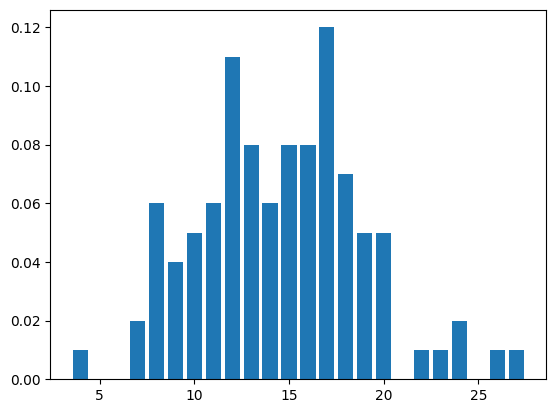

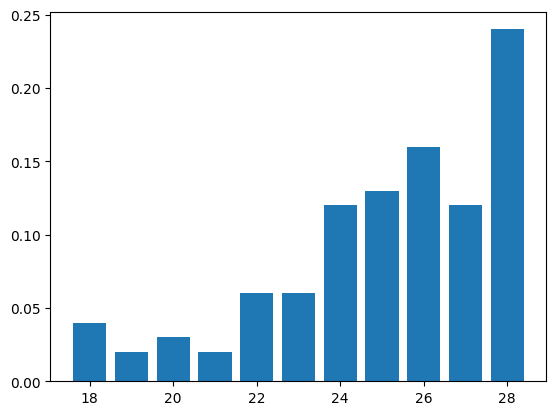

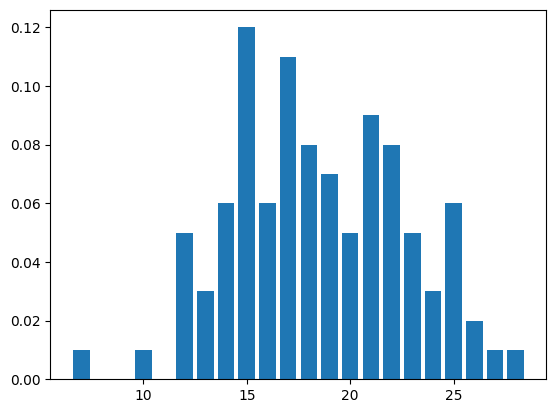

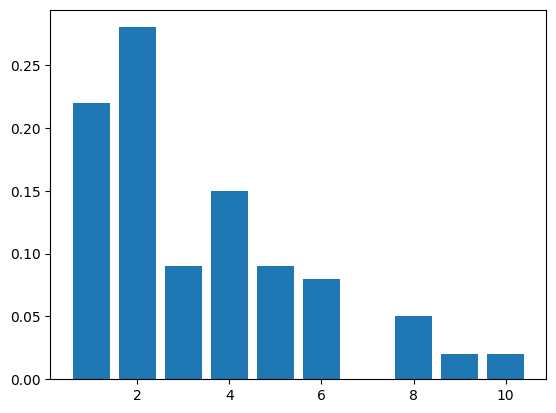

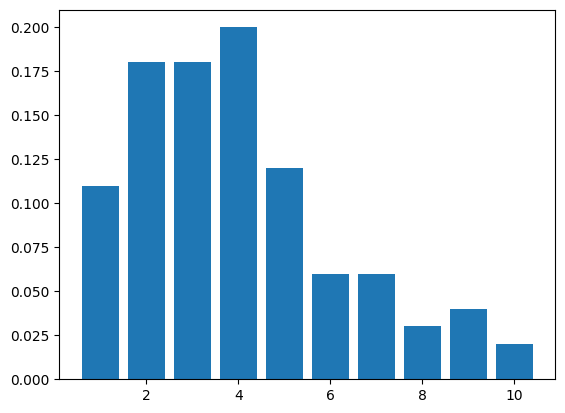

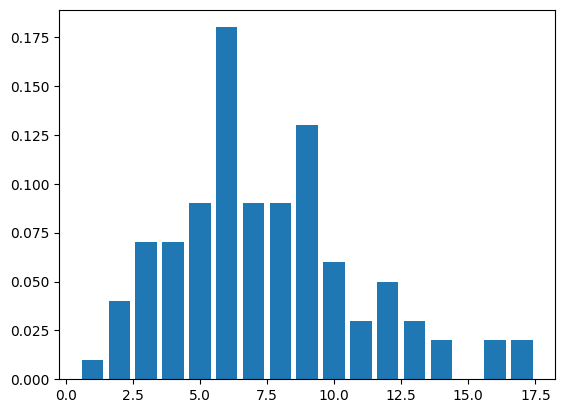

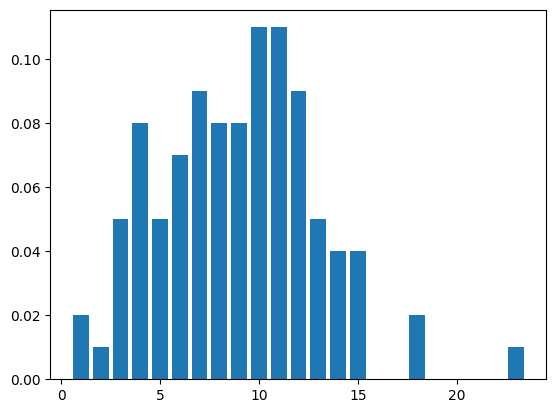

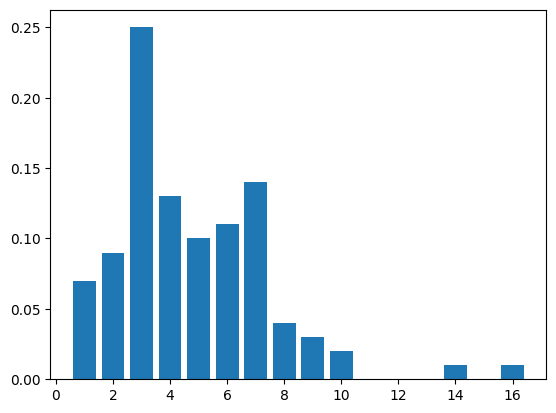

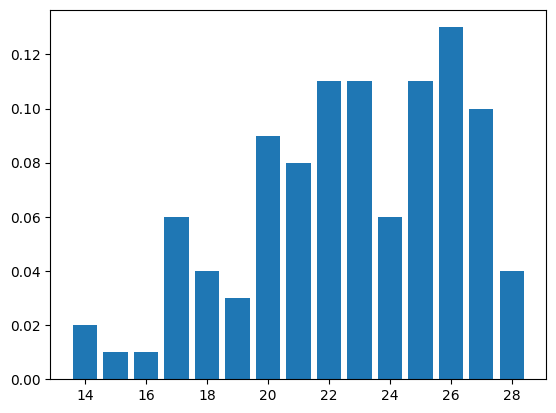

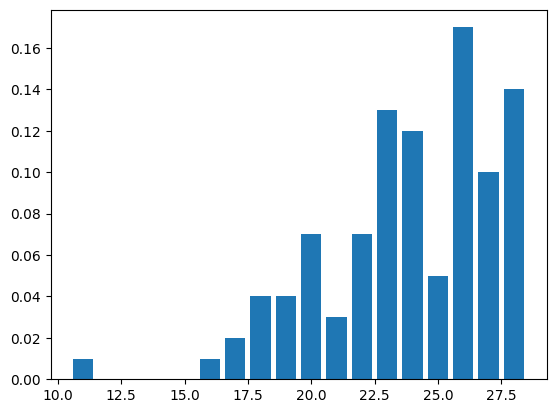

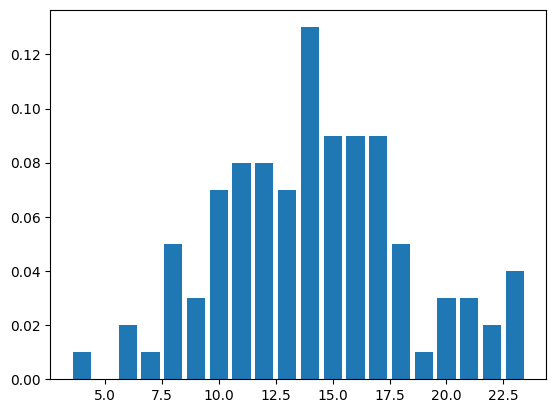

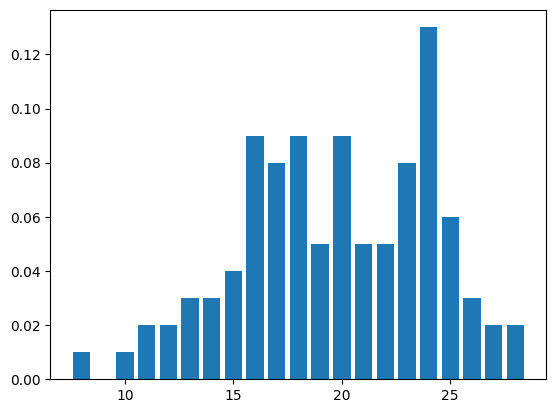

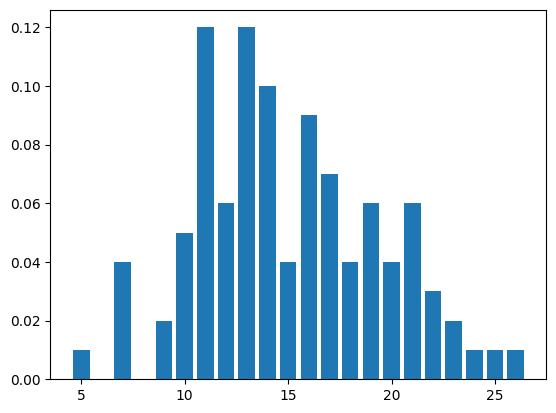

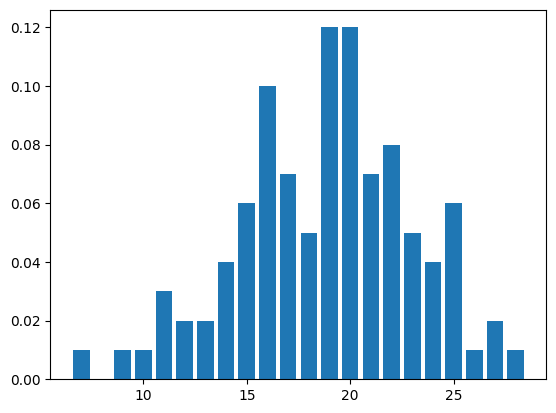

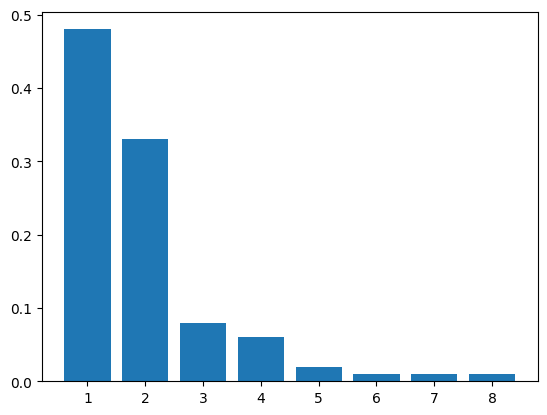

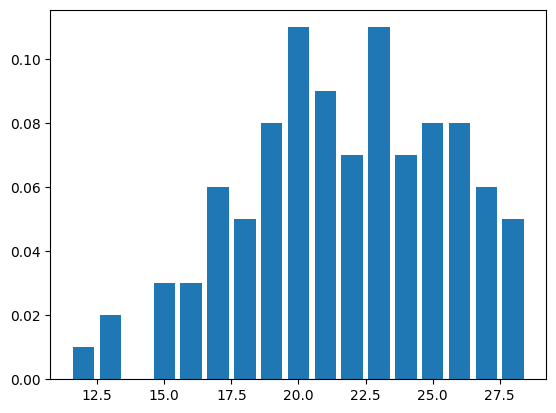

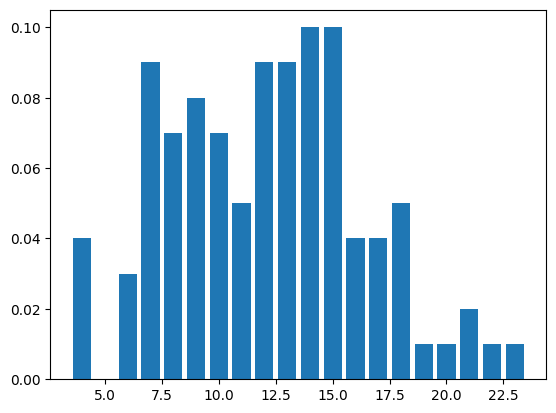

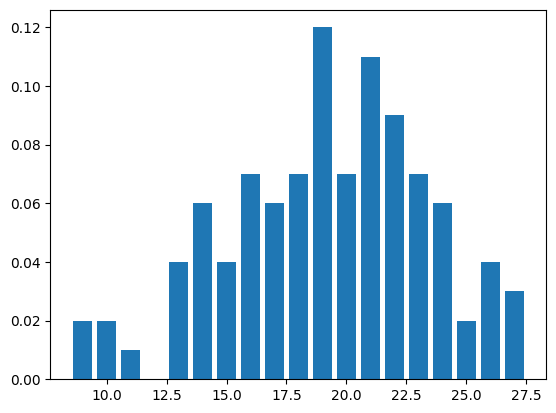

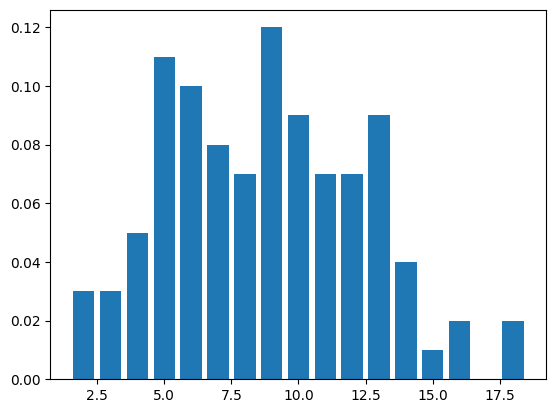

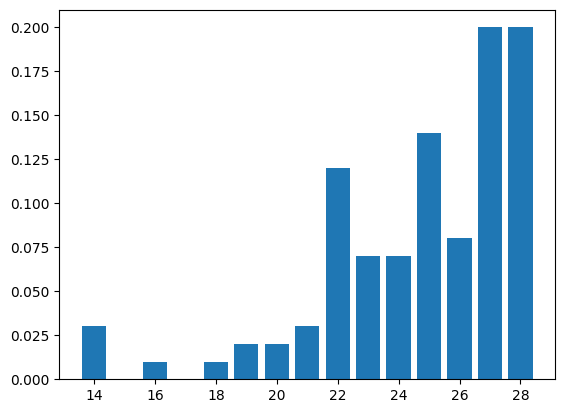

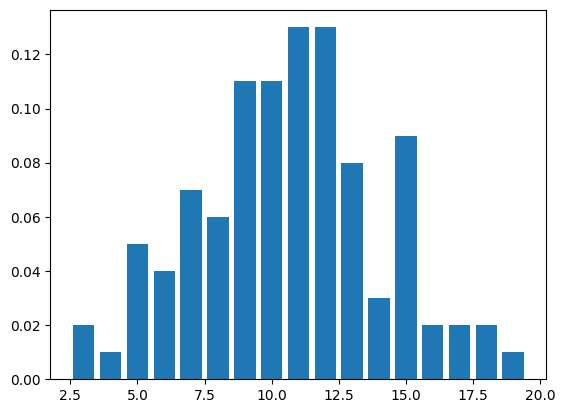

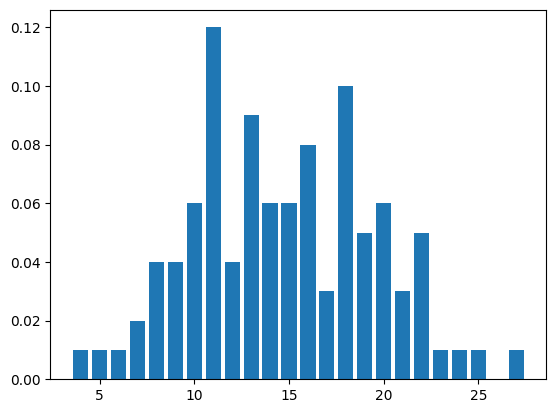

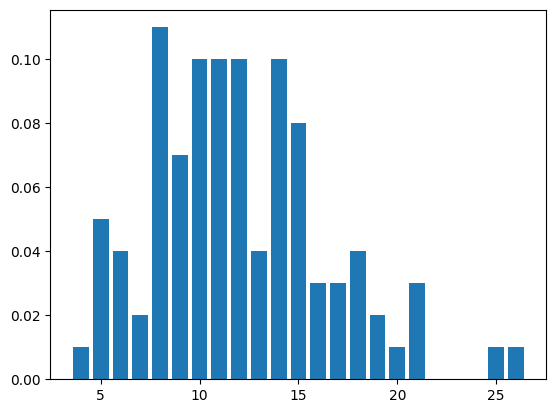

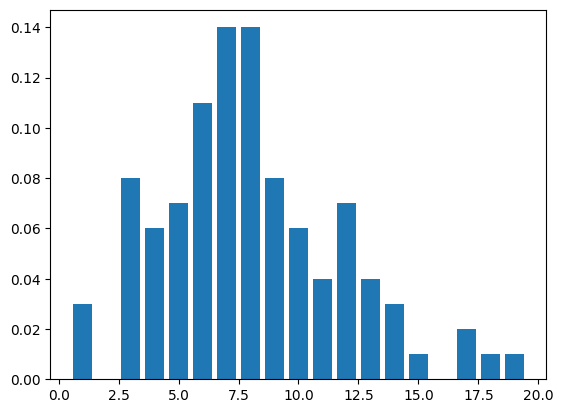

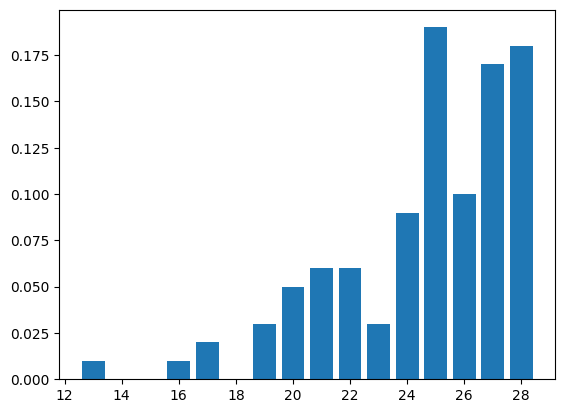

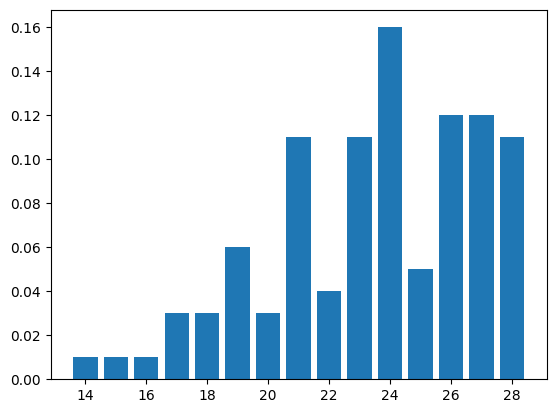

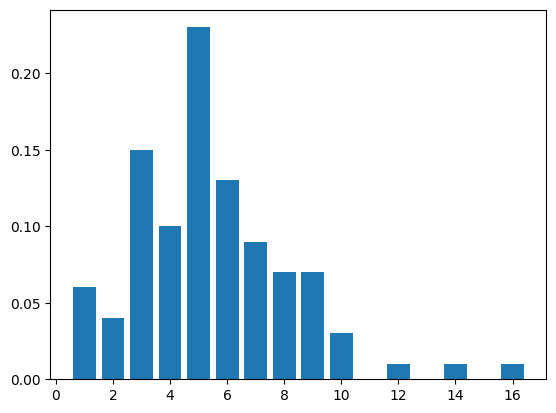

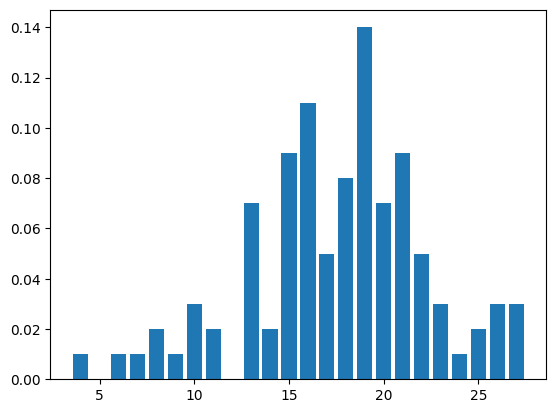

In [498]:
for i in ALL_TEAM_IDS:
    ranking_team = df_ranking_season2_proba[f"TeamID_{i}"]
    ranking_team_plot = ranking_team[ranking_team!=0]
    plt.bar(ranking_team_plot.index, ranking_team_plot.values)
    plt.show()

## Real ranking of season 2